In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

plt.style.use('/Users/alexg/Python Projects/alex_style.mplstyle')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

from TeraToptica import TeraFlashAnalyzer as TFA, TeraFlashConfig as TFC
from TeraToptica import TeraScanAnalyzer as TSA, TeraScanConfig as TSC

mask_bounds = (
              (0, 150), # mask low frequency data
              (545, 570), (740, 765), (1080, 1120), (1150, 1175), (1190, 1245), (1390, 1430), # mask waterlines
              (1585, 1810), (1855, 1950),
              (1500, 10000) # model does not converge above ~1500 GHz
              )

mask_starts = np.array((mask_bounds))[:,0]
mask_stops = np.array((mask_bounds))[:,1]

from pathlib import Path

BASE_DIR = Path.cwd()
TF_DIR = BASE_DIR / "data" / "TeraFlash"
TS_DIR = BASE_DIR / "data" / "TeraScan"

# TeraFlash

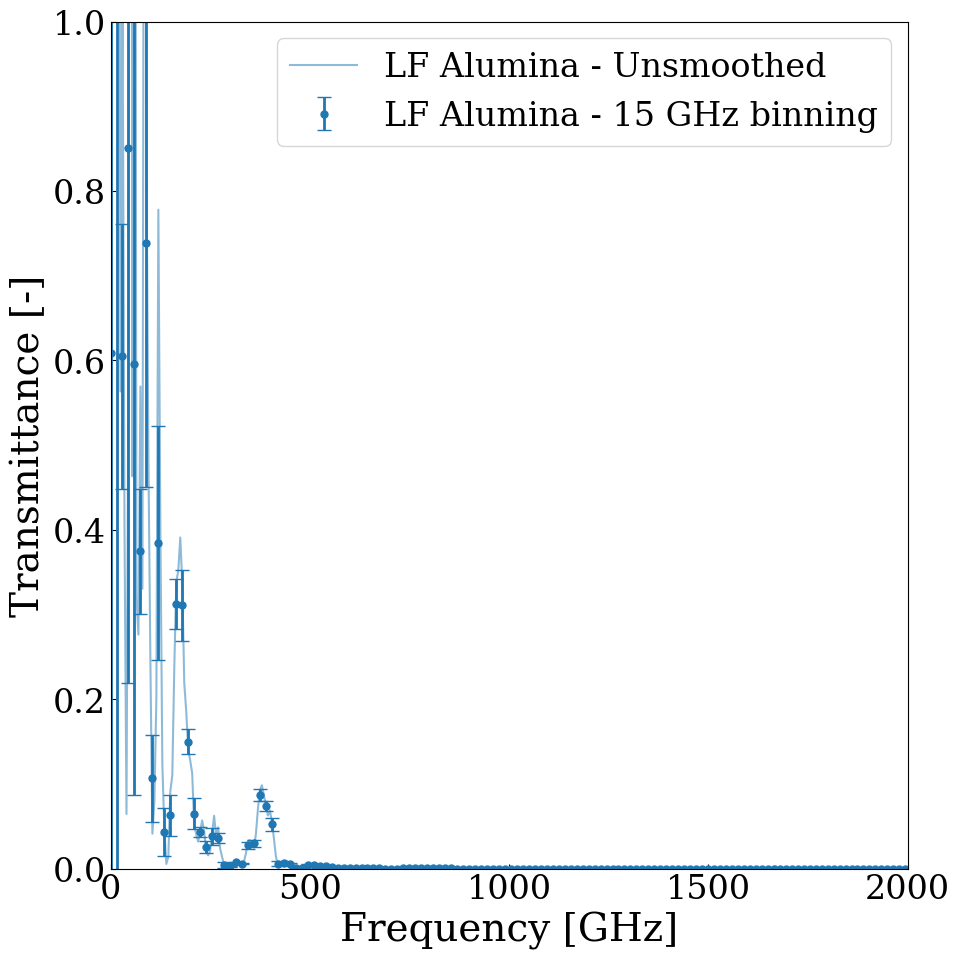

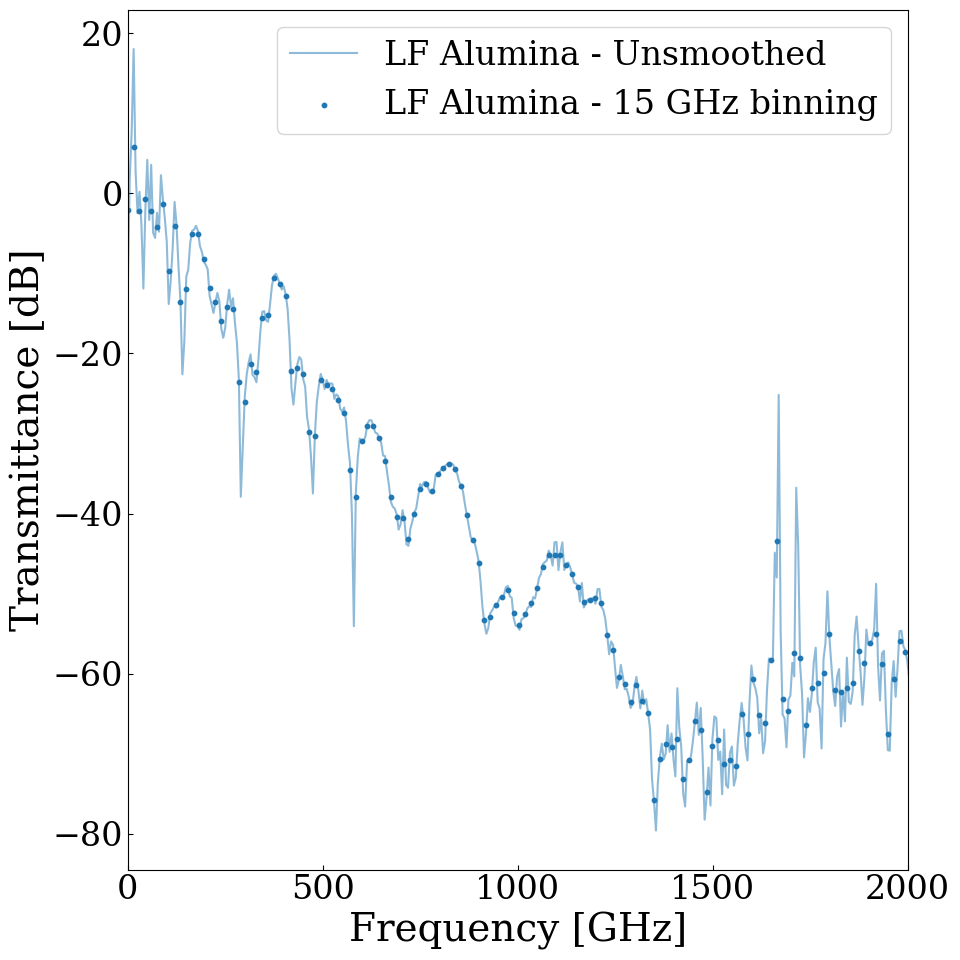

In [55]:
base_fn   = 'open_575-775ps_1000avgs'
sample_fn = 'al_LF_575-775ps_1000avgs'

tf_cfg = TFC(
    window='boxcar',          # smoothing window in frequency domain
    window_size=15,           # GHz
    mask_bounds=mask_bounds,
    use_FFT=False,             # use FFT-from-pulse method
)

# Intantiate the analyse object and retrieve spectra
al_LF = TFA(
    path_measurement=TF_DIR,
    base=base_fn,
    sample=sample_fn,
    config=tf_cfg,
)

f_al, ut_al = al_LF.get_spectra()
f_al, t_al, ut_al, mask_al, err_al, boxnum_al = al_LF.get_smoothed_spectra()
ut_al_dB, t_al_dB = 10 * np.log10(ut_al), 10 * np.log10(t_al)
err_al_dB = 10 * np.log10(ut_al + err_al) - ut_al_dB

# Plot
plt.figure(figsize=(10, 10))
plt.plot(f_al, ut_al, label='LF Alumina - Unsmoothed', color='tab:blue', alpha=0.5)
plt.errorbar(f_al[::boxnum_al], t_al[::boxnum_al], yerr=err_al[::boxnum_al],
    fmt='o', markersize=5, linewidth=2, capsize=5,
    label='LF Alumina - 15 GHz binning', color='tab:blue'
    )

plt.xlabel('Frequency [GHz]')
plt.ylabel('Transmittance [-]')
plt.xlim(0, 2000)
plt.ylim(0, 1)
plt.legend(loc='upper right', fontsize=24)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(f_al, ut_al_dB, label='LF Alumina - Unsmoothed', color='tab:blue', alpha=0.5)
plt.scatter(f_al[::boxnum_al], t_al_dB[::boxnum_al], s=10, label='LF Alumina - 15 GHz binning', color='tab:blue')

plt.xlabel('Frequency [GHz]')
plt.ylabel('Transmittance [dB]')
plt.xlim(0, 2000)
# plt.ylim(0, 1)
plt.legend(loc='upper right', fontsize=24)
plt.tight_layout()
plt.show()

## TeraFlash Phase Example

C:\Users\Shreya Sutariya\AppData\Local\Temp\ipykernel_16596\3563661675.py:10: RuntimeWarning: divide by zero encountered in divide
  delta_L = phase_diff*const.c/ (2*np.pi*f_al*1e9)  # in meters


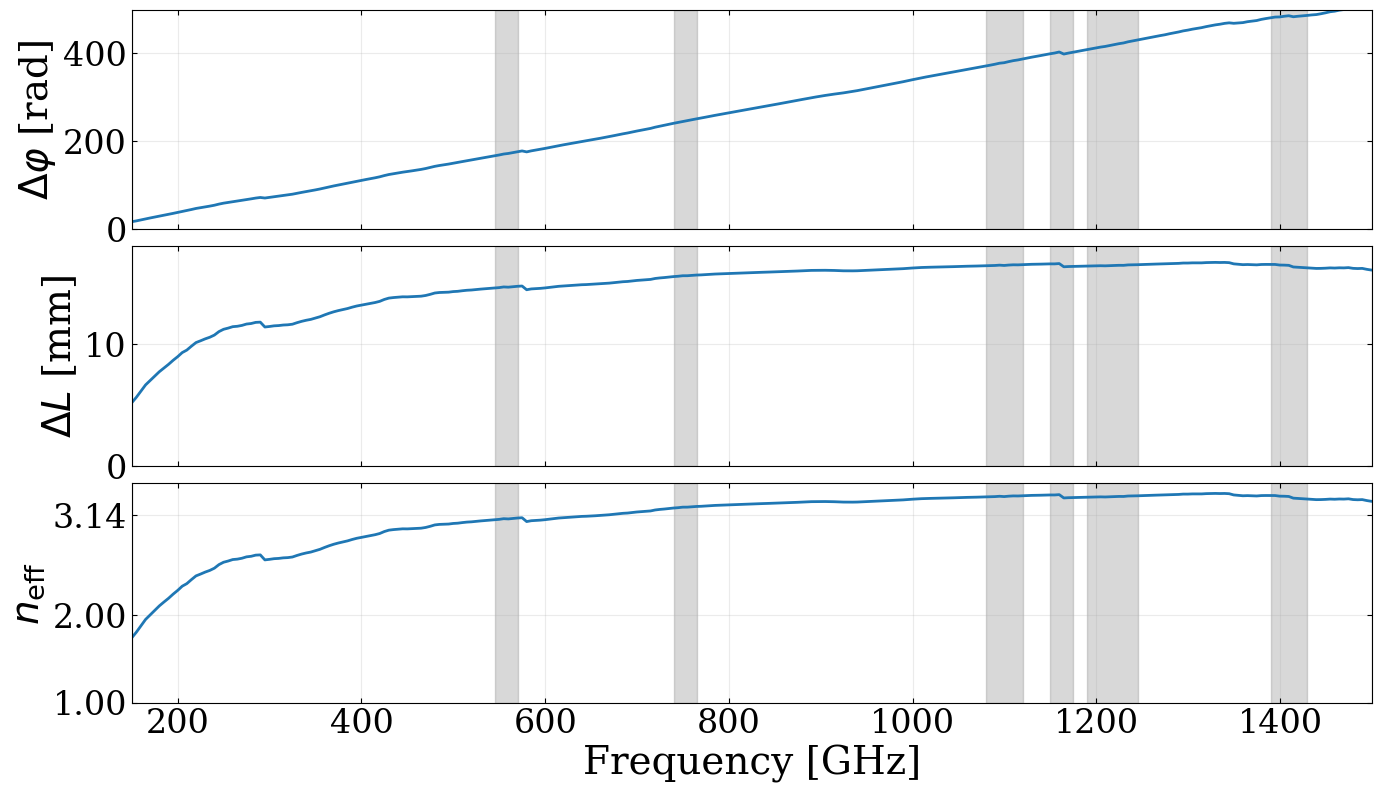

In [76]:
theta_al, theta_base = al_LF.get_phases()

phase_diff = np.abs(theta_al - theta_base)

while phase_diff[20] < 0:
    phase_diff += 2*np.pi
while phase_diff[20] >= 2*np.pi:
    phase_diff -= 2*np.pi

delta_L = phase_diff*const.c/ (2*np.pi*f_al*1e9)  # in meters
n = 1 + delta_L / (7e-3) #Guessed thickness ~ 7 mm

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 9))

axs[0].plot(f_al, phase_diff, color='tab:blue', lw=2)
axs[1].plot(f_al, delta_L*1e3, color='tab:blue', lw=2)
axs[2].plot(f_al, n, color='tab:blue', lw=2)

# Axis labels
axs[0].set_ylabel(r'$\Delta \varphi$ [rad]')
axs[1].set_ylabel(r'$\Delta L$ [mm]')
axs[2].set_ylabel(r'$n_{\rm eff}$')
axs[2].set_xlabel('Frequency [GHz]')

# Limits / ticks
for ax in axs:
    for i, j in zip(mask_starts, mask_stops):
        ax.axvspan(i, j, color='gray', alpha=0.3)
    ax.set_xlim(150, 1500)
    # ax.set_xlim(0, 200)
    ax.grid(True, alpha=0.25)
    ax.tick_params(direction='in', top=True, right=True)

axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 18)
axs[2].set_ylim(1.0, 3.5)
axs[1].set_yticks([0, 10])
axs[2].set_yticks([1, 2, 3.14])
# Legend (single, clean)

# Remove x tick labels on upper panels (sharex already, but makes it cleaner)
plt.subplots_adjust(hspace=0.08)
axs[0].label_outer()
axs[1].label_outer()
plt.show()


# TeraScan Example

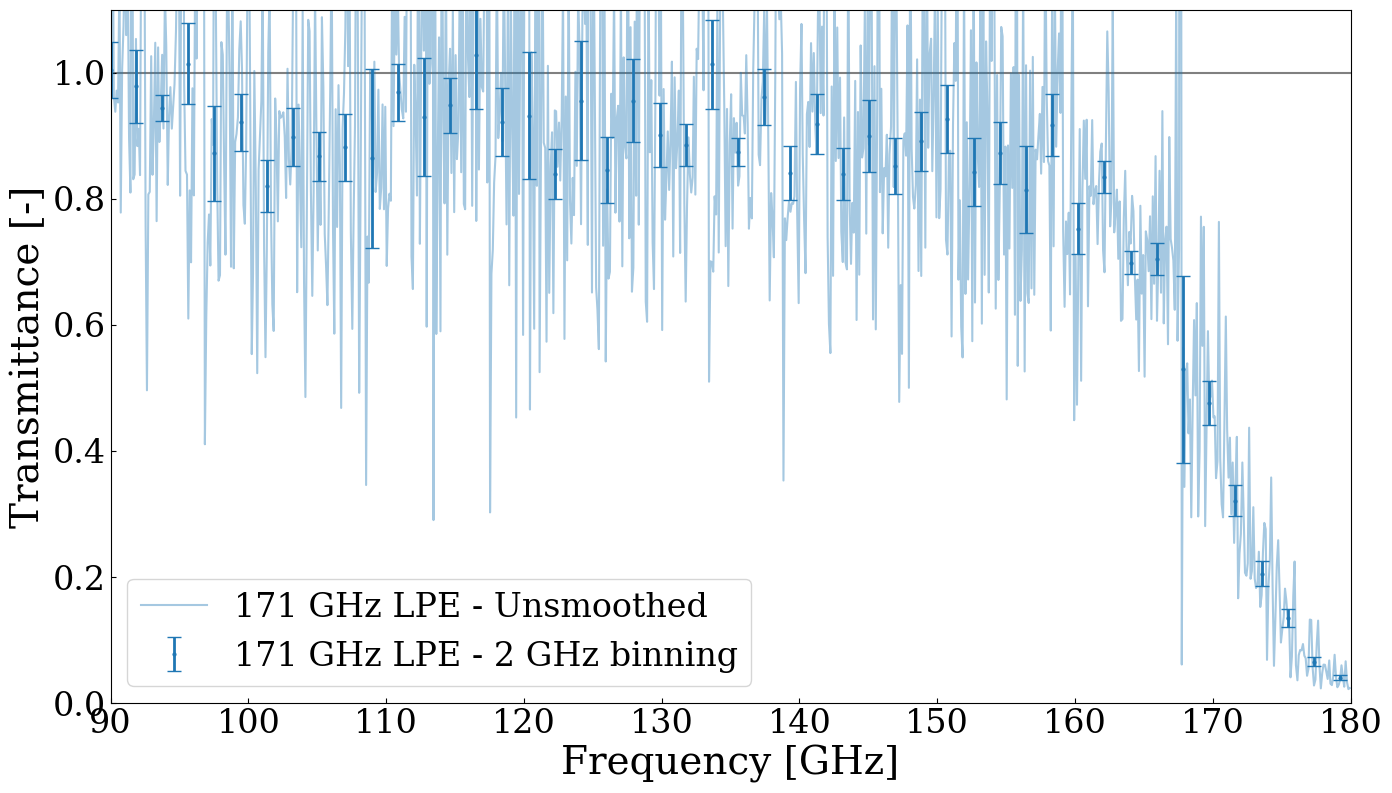

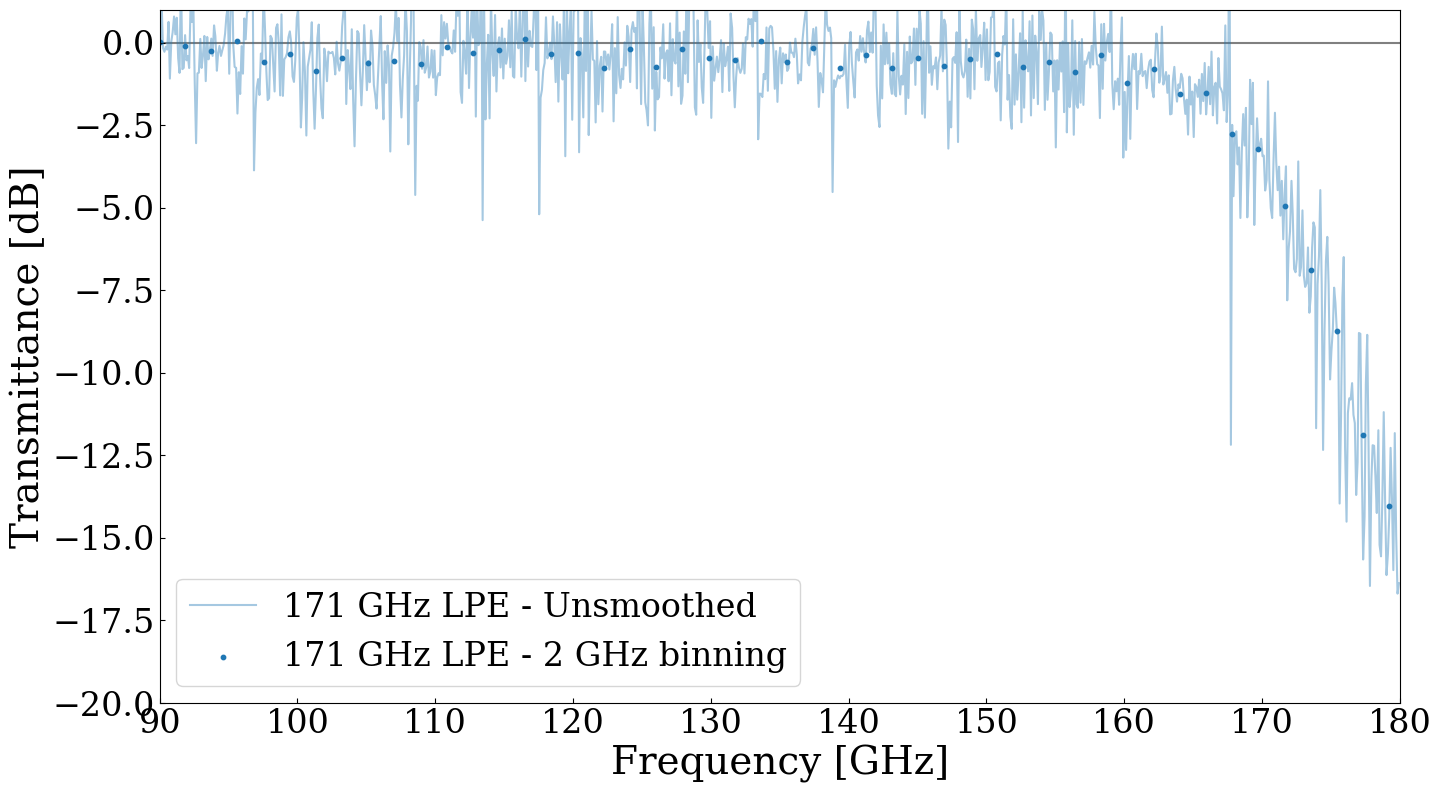

In [78]:
cfg_str = TSC(
    window='boxcar',
    window_size=2,
    mask_bounds=mask_bounds,
    include_mes_err=True,
    i_dc=14e-3,
    fiber_stretcher=True,    # <- Utilizes a fiber stretcher in the measurement setup
    open_stem=None,
)

ts = TSA(TS_DIR, 'LPE_5o7cm^-1_90-180ghz', 'open_90-180ghz', config=cfg_str)

f_LPE, t_LPE, ut_LPE, mask_LPE, err_LPE, boxnum_LPE = ts.get_smoothed_spectra()

ut_LPE_dB, t_LPE_dB = 10 * np.log10(ut_LPE), 10 * np.log10(t_LPE)

LPE_amp, base_amp = ts.get_currents()
LPE_pc, base_pc = ts.get_mod_currents()

plt.figure(figsize=(16, 9))

plt.plot(f_LPE, ut_LPE, alpha=0.4, color='tab:blue', label='171 GHz LPE - Unsmoothed')
plt.errorbar(f_LPE[::boxnum_LPE], t_LPE[::boxnum_LPE], yerr=err_LPE[::boxnum_LPE], 
             fmt='o', markersize=2, linewidth=2, capsize=5,
             color='tab:blue', label='171 GHz LPE - 2 GHz binning')
plt.axhline(1, color='gray', zorder=-1)

plt.xlabel('Frequency [GHz]')
plt.ylabel('Transmittance [-]')

plt.ylim(0, 1.1)
plt.xlim(90, 180)
plt.legend(loc='lower left', fontsize=24)
# plt.title('FP3697 Transmission Comparison')
plt.subplots_adjust(hspace=0.1)
plt.show()

plt.figure(figsize=(16, 9))

plt.plot(f_LPE, ut_LPE_dB, alpha=0.4, color='tab:blue', label='171 GHz LPE - Unsmoothed')
plt.scatter(f_LPE[::boxnum_LPE], t_LPE_dB[::boxnum_LPE], s=10, color='tab:blue', label='171 GHz LPE - 2 GHz binning')
plt.axhline(0, color='gray', zorder=-1)

plt.xlabel('Frequency [GHz]')
plt.ylabel('Transmittance [dB]')

plt.ylim(-20, 1)
plt.xlim(90, 180)
plt.legend(loc='lower left', fontsize=24)
# plt.title('FP3697 Transmission Comparison')
plt.subplots_adjust(hspace=0.1)
plt.show()


## TeraScan Photocurrents explained 
All prior plots in this notebook are fractional in units of fractional POWER = (sample current^2)/(reference current^2). The below plots are in units of photocurrent (measured in nA). The modulated photocurrent is the signal if a fiber stretcher is not used. The modulated photocurrent (ampliude) is measured directly when a fiberstretcher is utilized.

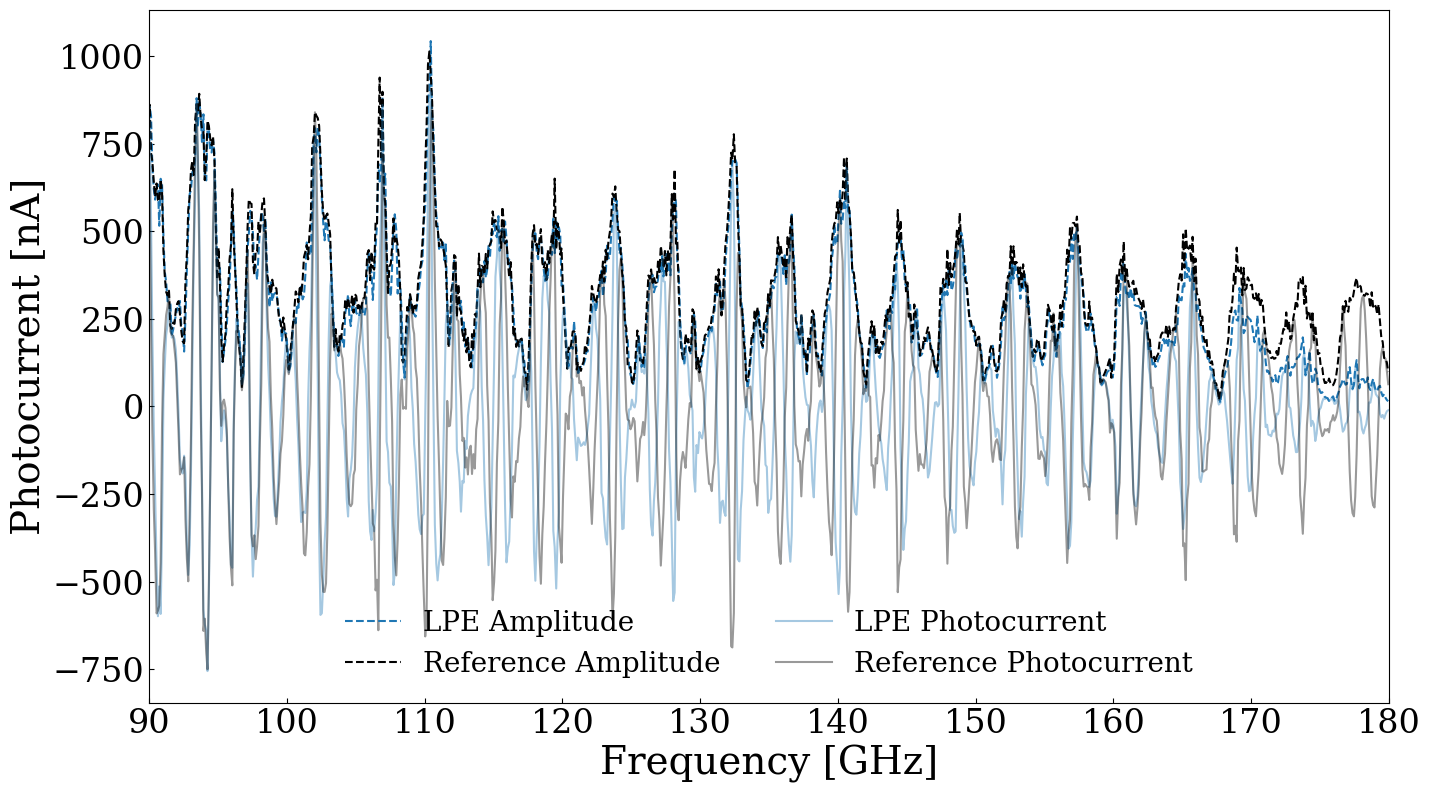

In [4]:
plt.figure(figsize=(16, 9))

plt.plot(f_LPE, LPE_amp, ls='--', color='tab:blue', label='LPE Amplitude')
plt.plot(f_LPE, base_amp, ls='--', color='k', label='Reference Amplitude')

plt.plot(f_LPE, LPE_pc, alpha=0.4, color='tab:blue', label='LPE Photocurrent')
plt.plot(f_LPE, base_pc, alpha=0.4, color='k', label='Reference Photocurrent')

plt.xlabel('Frequency [GHz]')
plt.ylabel('Photocurrent [nA]')

# plt.ylim(0, 1.1)
plt.xlim(90, 180)
plt.legend(loc='lower center', ncol=2, fontsize=20, frameon=False)
# plt.title('FP3697 Transmission Comparison')
plt.subplots_adjust(hspace=0.1)
plt.show()